# Beamsize minimization with Xopt

## define the diagnostic

In [1]:
from measurement import get_DYG14, set_camera, set_background

save_image_location = "/home/awa/awa_data/01-19_LPSMeasurement/"
image_diagnostic = get_DYG14()
image_diagnostic.save_image_location = save_image_location
image_diagnostic.target_charge = None


In [24]:
set_camera(image_diagnostic)

setting camera DYG14
192.168.2.139
setting IP address 192.168.2.111
setting gain


CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:cam1:Gain", Connecting to: awa5:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Fri Jan 19 2024 17:02:09.597414283
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:cam1:Gain", Connecting to: awa5:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Fri Jan 19 2024 17:02:09.597651801
..................................................................


starting acquisition


setting camera DYG14


CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArrayData", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Fri Jan 19 2024 15:28:24.428071133
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArraySize0_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Fri Jan 19 2024 15:28:24.428852061
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArraySize1_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Fri Jan 19 2024 15:28:24.429053605
................................................................

192.168.2.111
ip address already set
starting acquisition
please shutter beam


please un-shutter beam


background file: /home/awa/awa_data/01-19_LPSMeasurement/DYG14_background.npy
displaying image
fitting image


AWAEPICSImageDiagnostic(screen_name='13ARV1', ip_address='192.168.2.111', alias='DYG14', array_data_suffix='image1:ArrayData', array_n_cols_suffix='image1:ArraySize0_RBV', array_n_rows_suffix='image1:ArraySize1_RBV', resolution_suffix=None, resolution=1.0, beam_shutter_pv=None, extra_pvs=[], background_file='/home/awa/awa_data/01-19_LPSMeasurement/DYG14_background.npy', save_image_location='/home/awa/awa_data/01-19_LPSMeasurement/', roi=ROI(xcenter=556, ycenter=806, xwidth=700, ywidth=700), gain=1.0, min_log_intensity=4.0, bounding_box_half_width=3.0, wait_time=1.0, n_fitting_restarts=1, visualize=True, verbose=True, return_statistics=False, threshold=0.0, target_charge=None, target_charge_pv='AWAVXI11ICT:Ch4', charge_atol=1e-10, testing=False)

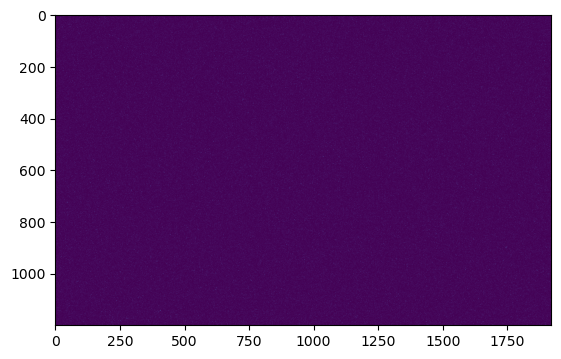

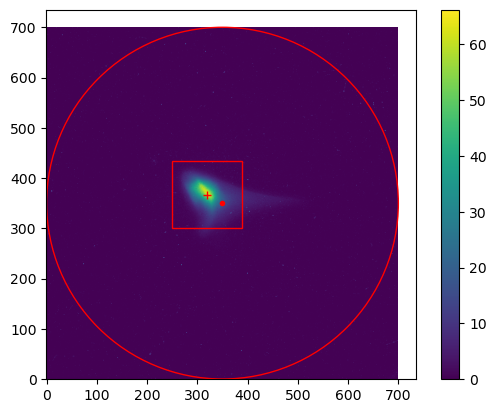

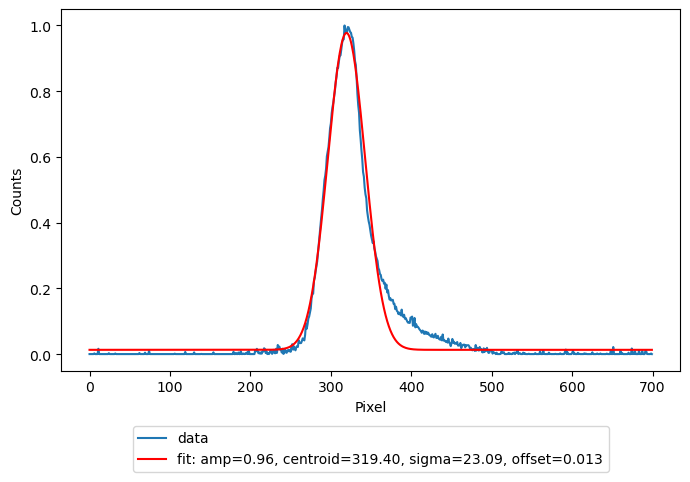

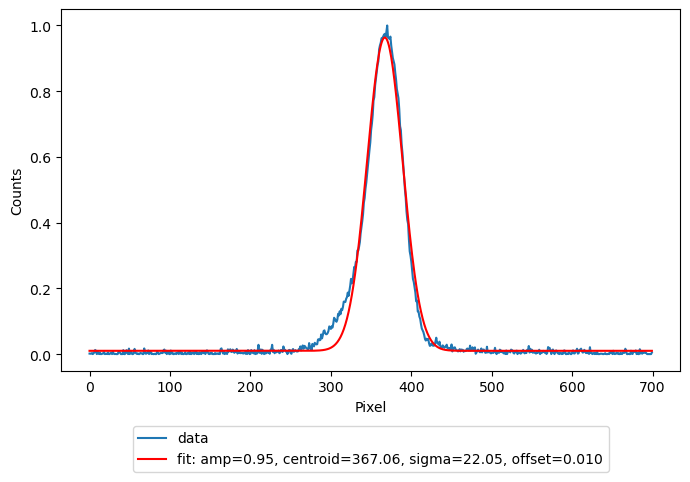

In [2]:
set_background(image_diagnostic)

In [3]:
image_diagnostic

AWAEPICSImageDiagnostic(screen_name='13ARV1', ip_address='192.168.2.111', alias='DYG14', array_data_suffix='image1:ArrayData', array_n_cols_suffix='image1:ArraySize0_RBV', array_n_rows_suffix='image1:ArraySize1_RBV', resolution_suffix=None, resolution=1.0, beam_shutter_pv=None, extra_pvs=[], background_file='/home/awa/awa_data/01-19_LPSMeasurement/DYG14_background.npy', save_image_location='/home/awa/awa_data/01-19_LPSMeasurement/', roi=ROI(xcenter=556, ycenter=806, xwidth=700, ywidth=700), gain=1.0, min_log_intensity=4.0, bounding_box_half_width=3.0, wait_time=1.0, n_fitting_restarts=1, visualize=True, verbose=True, return_statistics=False, threshold=0.0, target_charge=None, target_charge_pv='AWAVXI11ICT:Ch4', charge_atol=1e-10, testing=False)

displaying image
fitting image


{'Cx': 321.54489935825575,
 'Cy': 367.1747849573613,
 'Sx': 25.316771344341827,
 'Sy': 21.65304996066527,
 'bb_penalty': -217.15996888886852,
 'total_intensity': 274192.80000000005,
 'log10_total_intensity': 5.438056046509934,
 'AWAVXI11ICT:Ch4': 1.741182679082941e-08}

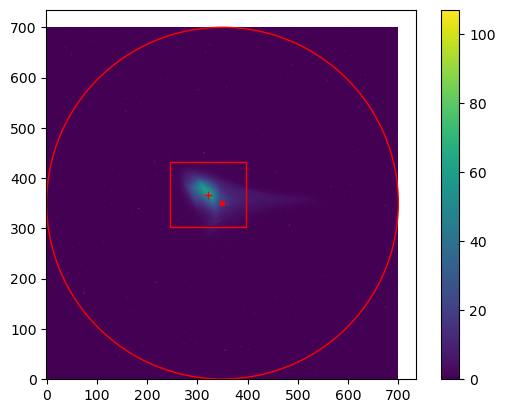

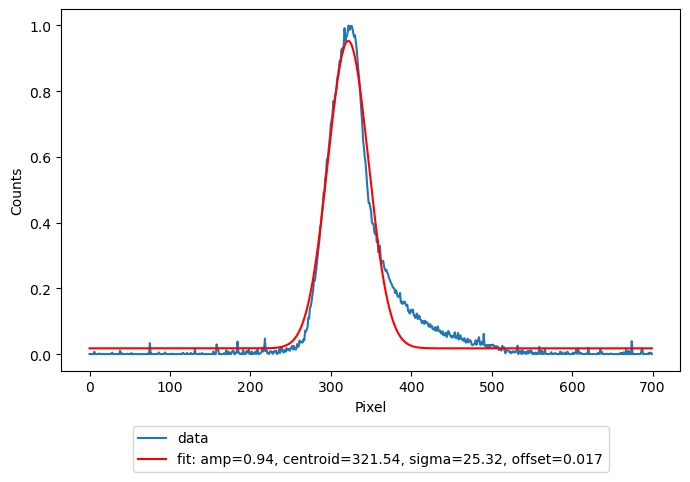

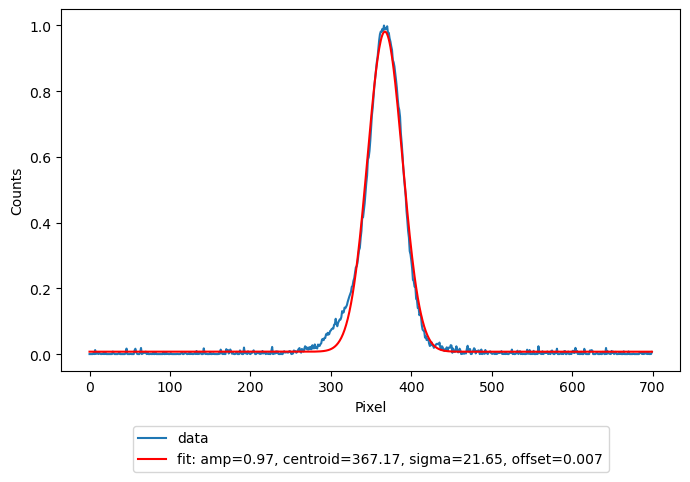

In [4]:
image_diagnostic.test_measurement()

### Define the evaluator

In [5]:
from epics import caput, caget
from xopt import Evaluator
import time
import numpy as np

IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
            "log10_total_intensity": ["GREATER_THAN", image_diagnostic.min_log_intensity]
        }
image_diagnostic.visualize = False
def evaluate_function(inputs: dict) -> dict:
    global image_diagnostic
    # caput values
    for name, val in inputs.items():
        caput(name, val)

    # wait for changes to occur - use small wait time for interpolated measurements
    time.sleep(1)

    results = image_diagnostic.measure_beamsize(1, **inputs)

    # add total beam size
    sigma_xy = np.sqrt(np.array(results["Sx"])**2 + np.array(results["Sy"])**2)
    roundness = np.abs(np.array(results["Sx"]) - np.array(results["Sy"]))
    results["total_size"] = sigma_xy + roundness
    print(sigma_xy, roundness, results["total_size"], results["bb_penalty"])
    return results

evaluator = Evaluator(function=evaluate_function)

### Define VOCS
Here we define the names and ranges of input parameters, the names and settings of
objectives, and the names and settings of constraints. Note that the keys here should
 be referenced in the evaluate function above.

In [6]:
from xopt import VOCS

# define control PVs and ranges here
vocs = VOCS(
    variables = {
        #"AWA:Bira3Ctrl:Ch10": [-1, 1], # Quad 4:9
        "AWA:Bira3Ctrl:Ch11": [0, 2.0], # Quad 3:11
        "AWA:Bira4Ctrl:Ch10": [0, 2.0], # Quad 4:10
        "AWA:Bira4Ctrl:Ch11": [-1.0, 1.0], # Quad 4:11
    },
    objectives = {"total_size":"MINIMIZE"},
    constraints = IMAGE_CONSTRAINTS
)

### Define the Generator

In [7]:
from xopt.generators import get_generator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

model_constructor = StandardModelConstructor(use_low_noise_prior=False)
generator = get_generator("expected_improvement")(
    vocs=vocs, gp_constructor=model_constructor, 
    n_interpolate_points=5, 
    turbo_controller="optimize",
)
generator.numerical_optimizer.max_time = 10.0
#generator.turbo_controller.failure_tolerance = 6
#generator.turbo_controller.success_tolerance = 6

###  Combine into Xopt object

In [8]:
from xopt import Xopt
dump_filename = save_image_location + "/beamsize_minimization.yml"
X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator, dump_file=dump_filename)

## Introspection
Objects in Xopt can be printed to a string or dumped to a text file for easy
introspection of attributes and current configuration.

In [9]:
# Convenient representation of the state.
X


            Xopt
________________________________
Version: 2.1.0+27.g53bd9d64.dirty
Data size: 0
Config as YAML:
dump_file: /home/awa/awa_data/01-19_LPSMeasurement//beamsize_minimization.yml
evaluator:
  function: __main__.evaluate_function
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    use_low_noise_prior: false
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: 5
  n_monte_carlo_samples: 128
  name: expected_improvement
  numerical_optimizer:
    max_iter: 2000
    max_time: 10.0
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller:
    batch_size: 1
    best_value: null
    center_x: null
    dim: 3
    failure_counter: 0
    failure_tolerance: 2
    length: 0.25
    length_max: 2.0
    leng

### Initialization

In [25]:
from epics import caget_many
from xopt.utils import get_local_region
import pandas as pd
# 0.684 	1.135 	0.146 0.5
X.evaluate_data(pd.DataFrame([{
    'AWA:Bira3Ctrl:Ch11': 0.684,
    'AWA:Bira4Ctrl:Ch10': 1.135,
    'AWA:Bira4Ctrl:Ch11': 0.146,
    "AWA:Bira3Ctrl:Ch10":0.0
}], columns=X.vocs.variable_names,index=[0]))

# get current point
current_value = dict(zip(X.vocs.variable_names, caget_many(X.vocs.variable_names)))

# get small region around current point to sample
random_sample_region = get_local_region(current_value,X.vocs, fraction=0.05)

random_sample_region

fitting image
nan nan nan 278.34032657398325


{'AWA:Bira3Ctrl:Ch11': [0.5840000000000001, 0.784],
 'AWA:Bira4Ctrl:Ch10': [1.035, 1.235],
 'AWA:Bira4Ctrl:Ch11': [0.045999999999999985, 0.246]}

CA.Client.Exception...............................................
    Context: "192.168.0.166:5064"
    Source File: ../tcpiiu.cpp line 926
    Current Time: Fri Jan 19 2024 17:20:04.734567802
..................................................................
CA.Client.Exception...............................................
    Context: "192.168.0.167:5064"
    Source File: ../tcpiiu.cpp line 926
    Current Time: Fri Jan 19 2024 17:20:11.927940312
..................................................................
Unexpected problem with CA circuit to server "192.168.0.166:5064" was "No route to host" - disconnecting
CA.Client.Exception...............................................
    Context: "192.168.0.166:5064"
    Source File: ../cac.cpp line 1237
    Current Time: Fri Jan 19 2024 17:35:30.684184481
..................................................................
Unexpected problem with CA circuit to server "192.168.0.167:5064" was "No route to host" - disconnecting
CA.Client

In [11]:
X.data

,AWA:Bira3Ctrl:Ch11,AWA:Bira4Ctrl:Ch10,AWA:Bira4Ctrl:Ch11,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,AWAVXI11ICT:Ch4,save_filename,total_size,xopt_runtime,xopt_error
0,0.611955,1.0429,0.236258,319.144075,369.220332,24.471121,21.115539,-216.998549,296543.4,5.472088,1.747364e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,35.677429,2.297967,False


In [12]:
# random sample in a local region
X.random_evaluate(10, custom_bounds=random_sample_region)

fitting image
54.72251515795287 40.729184867473116 95.45170002542599 -116.09302444599862
fitting image
38.15725213322979 5.363157889239403 43.52041002246919 -206.4871555326094
fitting image
84.25780658161628 71.5387008342554 155.79650741587167 -55.74082700158311
fitting image
85.56424185749663 56.27713328728046 141.8413751447771 -52.63722811077656
fitting image
77.92094551050158 8.2275178187924 86.14846332929397 -56.488116787281854
fitting image
61.543915083744615 3.353964801616982 64.89787988536159 -139.36434293138083
fitting image
30.174737001081375 3.1846066953914374 33.35934369647281 -185.2340768423909
fitting image
58.36757167937422 17.484336164815943 75.85190784419017 -137.9483700831869
fitting image
64.92913858190269 55.38942250958336 120.31856109148606 -86.01913687916681
fitting image
34.1778786087593 4.578086202995127 38.755964811754424 -205.58799843885993


,AWA:Bira3Ctrl:Ch11,AWA:Bira4Ctrl:Ch10,AWA:Bira4Ctrl:Ch11,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,AWAVXI11ICT:Ch4,save_filename,total_size,xopt_runtime,xopt_error
0,0.568087,1.053947,0.184380,290.199563,392.934099,53.266875,12.537690,-116.093024,264260.8,5.422033,1.912676e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,95.451700,2.305018,False
1,0.670744,1.122763,0.314914,324.116650,364.059866,29.529243,24.166085,-206.487156,250384.0,5.398607,1.787789e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,43.520410,2.268117,False
2,0.541182,1.085248,0.223602,317.354794,395.355718,83.416413,11.877712,-55.740827,278243.0,5.444424,2.164465e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,155.796507,2.326198,False
3,0.518264,0.968370,0.207318,311.387868,362.791821,81.700128,25.422994,-52.637228,278715.4,5.445161,1.915772e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,141.841375,2.279222,False
4,0.690410,0.963505,0.238723,298.884321,318.013667,59.058403,50.830885,-56.488117,250014.6,5.397965,1.677209e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,86.148463,2.357832,False
5,0.674655,1.015195,0.265945,314.575860,350.506041,41.808814,45.162779,-139.364343,222060.8,5.346472,1.499987e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,64.897880,2.213879,False
6,0.688995,1.128764,0.140620,314.112619,418.335771,22.869567,19.684960,-185.234077,235839.8,5.372617,1.646415e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,33.359344,2.279374,False
7,0.557884,1.038290,0.308169,312.287345,358.954335,49.077775,31.593439,-137.948370,311302.8,5.493183,2.208280e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,75.851908,2.219560,False
8,0.542218,1.079398,0.240490,288.142217,392.254514,64.313006,8.923583,-86.019137,218273.2,5.339000,1.435316e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,120.318561,2.276399,False
9,0.599591,0.997103,0.194296,311.959823,369.226398,26.347804,21.769718,-205.587998,251617.4,5.400741,1.746659e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,38.755965,2.301498,False


In [13]:
# examine the data stored in Xopt
X.data

,AWA:Bira3Ctrl:Ch11,AWA:Bira4Ctrl:Ch10,AWA:Bira4Ctrl:Ch11,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,AWAVXI11ICT:Ch4,save_filename,total_size,xopt_runtime,xopt_error
0,0.611955,1.042900,0.236258,319.144075,369.220332,24.471121,21.115539,-216.998549,296543.4,5.472088,1.747364e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,35.677429,2.297967,False
1,0.568087,1.053947,0.184380,290.199563,392.934099,53.266875,12.537690,-116.093024,264260.8,5.422033,1.912676e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,95.451700,2.305018,False
2,0.670744,1.122763,0.314914,324.116650,364.059866,29.529243,24.166085,-206.487156,250384.0,5.398607,1.787789e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,43.520410,2.268117,False
3,0.541182,1.085248,0.223602,317.354794,395.355718,83.416413,11.877712,-55.740827,278243.0,5.444424,2.164465e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,155.796507,2.326198,False
4,0.518264,0.968370,0.207318,311.387868,362.791821,81.700128,25.422994,-52.637228,278715.4,5.445161,1.915772e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,141.841375,2.279222,False
5,0.690410,0.963505,0.238723,298.884321,318.013667,59.058403,50.830885,-56.488117,250014.6,5.397965,1.677209e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,86.148463,2.357832,False
6,0.674655,1.015195,0.265945,314.575860,350.506041,41.808814,45.162779,-139.364343,222060.8,5.346472,1.499987e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,64.897880,2.213879,False
7,0.688995,1.128764,0.140620,314.112619,418.335771,22.869567,19.684960,-185.234077,235839.8,5.372617,1.646415e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,33.359344,2.279374,False
8,0.557884,1.038290,0.308169,312.287345,358.954335,49.077775,31.593439,-137.948370,311302.8,5.493183,2.208280e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,75.851908,2.219560,False
9,0.542218,1.079398,0.240490,288.142217,392.254514,64.313006,8.923583,-86.019137,218273.2,5.339000,1.435316e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,120.318561,2.276399,False


In [14]:
# run optimization
for i in range(20):
    print(i)
    X.step()

0
fitting image
42.04712160658299 6.284284585558346 48.33140619214134 -131.74660221851892
fitting image
nan nan nan 54.652370594953425
fitting image
nan nan nan 47.83362552844676
fitting image
nan nan nan 67.88118604058798
fitting image
18.956290250550172 15.795394496823318 34.75168474737349 -177.43482098756883
1
fitting image
nan nan nan 59.13132322064655
fitting image
nan nan nan 47.33956700224769
fitting image
nan nan nan 38.93279451856
fitting image
nan nan nan 0.4799201451875774
fitting image
59.10597371197267 40.24042454470136 99.34639825667404 -124.57243049673292
2
fitting image
51.22735517205532 29.817506509112825 81.04486168116814 -147.7754001668987
fitting image
48.636846187048135 20.569763924915023 69.20661011196316 -161.65393108755657
fitting image
44.93700677486642 19.36110885614826 64.29811563101468 -170.09050138208517
fitting image
29.24193317444869 5.1318921399924875 34.37382531444118 -204.53004058104534
fitting image
31.187450323011888 5.96423996300998 37.1516902860218

<Axes: >

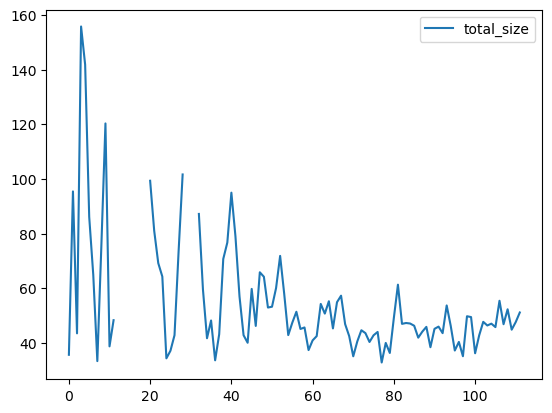

In [22]:
# visualize result
X.data.plot(y=X.vocs.objective_names[0])

<Axes: >

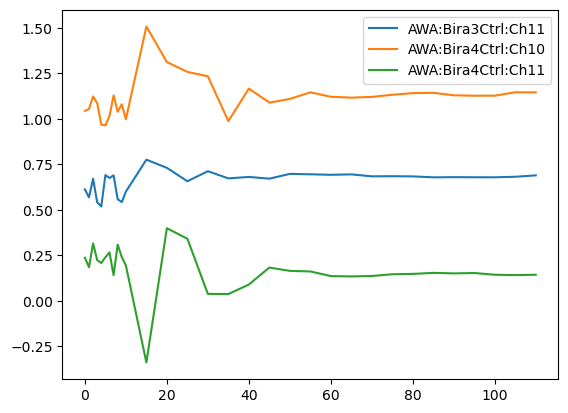

In [16]:
X.data.plot(y=X.vocs.variable_names)

displaying image
fitting image


{'Cx': 314.7902602968205,
 'Cy': 438.5994205553482,
 'Sx': 24.260990081776928,
 'Sy': 25.485064923205336,
 'bb_penalty': -152.75535129668282,
 'total_intensity': 279987.2,
 'log10_total_intensity': 5.447138177426382,
 'AWAVXI11ICT:Ch4': 1.58514063380858e-08}

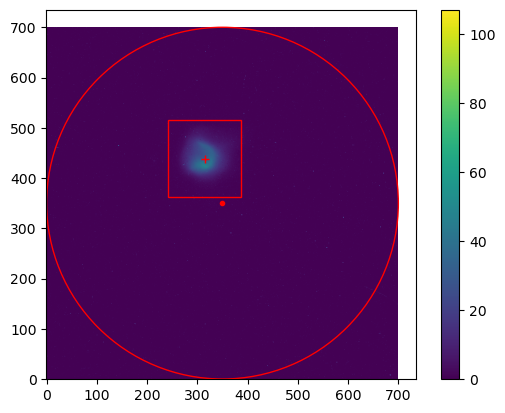

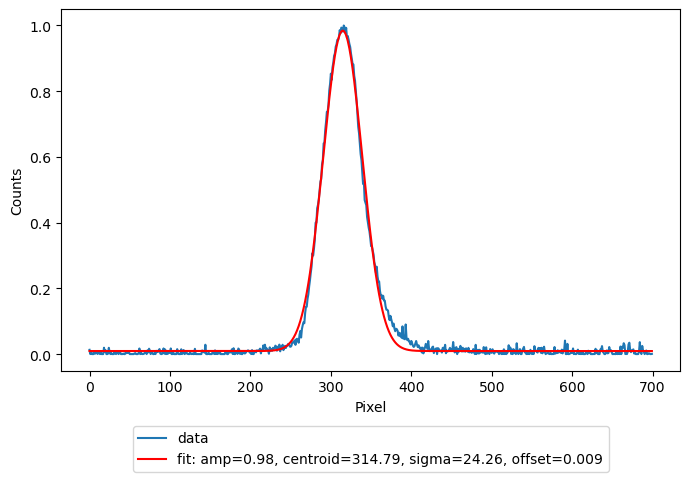

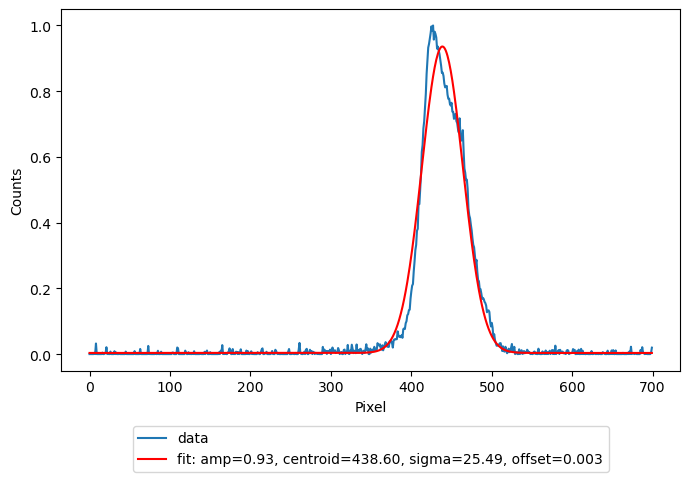

In [17]:
image_diagnostic.test_measurement()

In [18]:
idx, val = X.vocs.select_best(X.data)

In [19]:
X.evaluate_data(X.data.iloc[idx][X.vocs.variable_names])

fitting image
42.76061479769451 8.39491396885418 51.155528766548684 -154.50984586878621


,AWA:Bira3Ctrl:Ch11,AWA:Bira4Ctrl:Ch10,AWA:Bira4Ctrl:Ch11,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,AWAVXI11ICT:Ch4,save_filename,total_size,xopt_runtime,xopt_error
77,0.683898,1.135399,0.146478,322.498028,412.640219,25.746097,34.141011,-154.509846,314093.8,5.497059,1.884829e-08,/home/awa/awa_data/01-19_LPSMeasurement/DYG14_...,51.155529,2.254261,False


In [20]:
X.data.iloc[idx][X.vocs.variable_names].to_dict(orient="records")

[{'AWA:Bira3Ctrl:Ch11': 0.6838980909498434,
  'AWA:Bira4Ctrl:Ch10': 1.1353986202985502,
  'AWA:Bira4Ctrl:Ch11': 0.14647822369564867}]

displaying image
fitting image


{'Cx': 327.70360729125923,
 'Cy': 409.33784928333137,
 'Sx': 31.00043031280351,
 'Sy': 35.62081463894698,
 'bb_penalty': -147.72273159293997,
 'total_intensity': 342791.79999999993,
 'log10_total_intensity': 5.535030424519114,
 'AWAVXI11ICT:Ch4': 1.8875134562343253e-08}

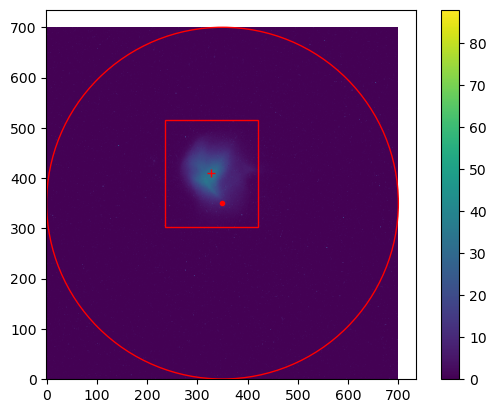

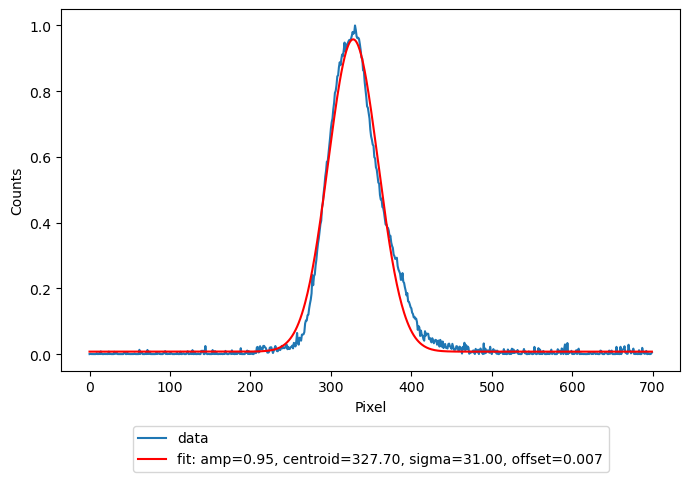

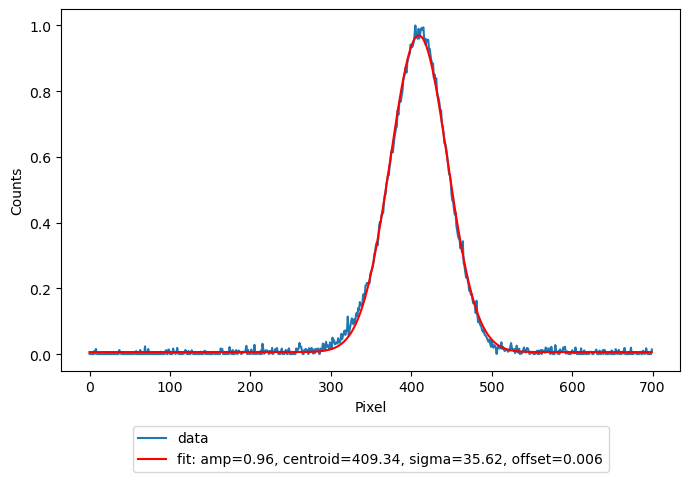

In [21]:
image_diagnostic.test_measurement()